In [7]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [8]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    return df

In [9]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [10]:
for route in routes:
    add_extra_data(route)

In [11]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [12]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

## Helper Functions

In [14]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [121]:
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]
cs = [colours[i] for i in range(len(colours))]

# Linear Regression Model

Pick 2 stops on a route. Calculate all the journey times between them. Make a dataset with attributes time of day (choosing the time slot when the bus left if the bus straddles 2 time slots), journey time, day of week.

Choose "North End Road" to "Phillimore Gardens" on route 9 inbound

In [122]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

b_9 = data.get("9")
north_end_rd = b_9.loc[(b_9['bus_stop_name'] == 'North End Road') & (b_9['direction'] == 'inbound')]
phillimore_g = b_9.loc[(b_9['bus_stop_name'] == 'Phillimore Gardens') & (b_9['direction'] == 'inbound')]
[_, north_end_rd_id, _, _, _] = north_end_rd.iloc[0]['vehicle_id'].split('_')
[_, phillimore_id, _, _, _] = phillimore_g.iloc[0]['vehicle_id'].split('_')

print(north_end_rd.shape)
print(phillimore_g.shape)

north_end_rd.head()

(882, 5)
(902, 5)


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
6,North End Road,2020-04-02 11:42:14,15455_490010357F_2020-04-02_out_4,2020-04-02 11:12:42,inbound
143,North End Road,2020-03-19 10:39:04,15458_490010357F_2020-03-19_out_0,2020-03-19 10:23:21,inbound
147,North End Road,2020-03-31 07:33:30,14462_490010357F_2020-03-31_out_0,2020-03-31 07:33:39,inbound
231,North End Road,2020-04-01 10:46:17,14468_490010357F_2020-04-01_out_0,2020-04-01 10:45:08,inbound
239,North End Road,2020-04-02 10:17:16,14558_490010357F_2020-04-02_out_4,2020-04-02 09:50:43,inbound


In [ ]:
start = time.time()
attrs = []

for i, journey in phillimore_g.iterrows():
    arr_dt = convert_time_to_datetime(journey['expected_arrival'])

    [bus_id, phillimore_id, date, direction, _] = journey['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + north_end_rd_id + '_' + date + '_' + direction + '_'

    for j, match in north_end_rd.iterrows():
        if match['vehicle_id'].startswith(to_match_id):
            leave_dt = convert_time_to_datetime(match['expected_arrival'])
            journey_time = arr_dt - leave_dt

            if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 30)):
                item = []
                item.append(journey_time)
                
                seconds = journey_time.total_seconds()
                item.append(seconds)
                
                d = dt.datetime.strptime(match['expected_arrival'][:10], '%Y-%m-%d')
                d = calendar.day_name[d.weekday()]
                item.append(d)
                
                t = get_time_of_day_group(journey['expected_arrival'])
                item.append(t)
                
                attrs.append(item)
                break

print("Getting journey times took {}".format(time.time() - start))

In [59]:
df = pd.DataFrame(attrs, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day'])
df.head()

,Journey Time,Journey Time (s),Day of Week,Time of Day
0,00:03:49,229.0,Monday,1
1,00:03:30,210.0,Tuesday,2
2,00:04:04,244.0,Tuesday,2
3,00:04:41,281.0,Sunday,3
4,00:04:17,257.0,Friday,3


### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [60]:
# partition data into 4 groups sorted by time of day
df = df.sort_values("Time of Day")
group1 = df.iloc[:(int(df.shape[0] / 4))]
group2 = df.iloc[(int(df.shape[0] / 4)):(int(2 * df.shape[0] / 4))]
group3 = df.iloc[(int(2 * df.shape[0] / 4)):(int(3 * df.shape[0] / 4))]
group4 = df.iloc[(int(3 * df.shape[0] / 4)):]

# get a random sample of 80% from each group to ensure the train and test
# have similar time of days
training = group1.sample(frac = 0.8)
training = training.append(group2.sample(frac = 0.8))
training = training.append(group3.sample(frac = 0.8))
training = training.append(group4.sample(frac = 0.8))

# validation is all the remaining data in merged_data that wasn't chosen for the training set
validation = df[~df.apply(tuple,1).isin(training.apply(tuple,1))]
print(training.shape, validation.shape)
training.head()

(664, 4) (149, 4)


,Journey Time,Journey Time (s),Day of Week,Time of Day
113,00:04:11,251.0,Tuesday,2
404,00:00:47,47.0,Monday,3
829,00:04:01,241.0,Saturday,1
294,00:03:05,185.0,Wednesday,2
797,00:04:14,254.0,Friday,2


## Single predictor variable

### Predict journey time based on time of day

In [115]:
from sklearn.metrics import mean_squared_error, r2_score

x_train = training[['Time of Day']]
x_test = validation[['Time of Day']]
y_train = training['Journey Time (s)']
y_test = validation['Journey Time (s)']
print(x_train.shape)

# Fit model
linreg = LinearRegression()
linreg.fit(x_train, y_train)

# Apply the model to the validation data to predict the ‘Journey Time’
y_pred = linreg.predict(x_test)

# Calculate measures of success
mse = mean_squared_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

print('Slope/Coefficients: ', linreg.coef_)
print('Intercept: ', linreg.intercept_)
print('The mean squared error is: ', mse)
# coefficient of determination = 1 is perfect prediction
print('The coefficient of determination is: ', r2_score)

(664, 1)
Slope/Coefficients:  [3.43076759]
Intercept:  278.85607702156994
The mean squared error is:  47660.151290557886
The coefficient of determination is:  -0.001612443574242839


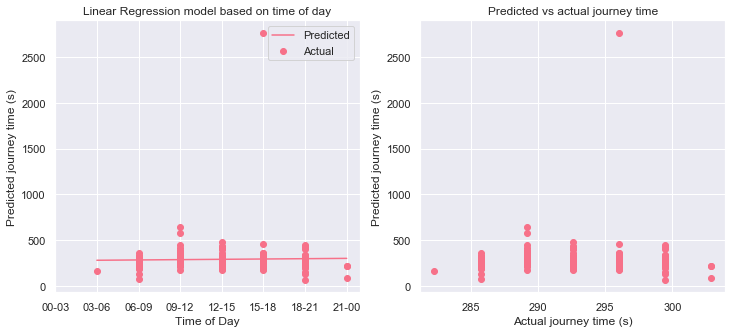

In [120]:
# Plot outputs
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
ax[0].scatter(x_test, y_test, label = "Actual")
ax[0].plot(x_test, y_pred, label = "Predicted")
ax[0].set_title("Linear Regression model based on time of day")
ax[0].set_xlabel("Time of Day")
ax[0].set_ylabel("Predicted journey time (s)")
ax[0].legend()
ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax[0].set_xticklabels(colour_to_time_label)

ax[1].scatter(y_pred, y_test)
ax[1].set_title("Predicted vs actual journey time")
ax[1].set_xlabel("Actual journey time (s)")
ax[1].set_ylabel("Predicted journey time (s)")
plt.show()

CONCLUSIONS:
We can see that a linear regression model does not fit well with these parameters. There is not enough of a difference in journey times throughout the day

### Predict journey time based on day of week

In [96]:
from sklearn.metrics import mean_squared_error, r2_score

y_train = training['Journey Time (s)']
y_test = validation['Journey Time (s)']

# Encode the days of week
le = preprocessing.LabelEncoder()
le.fit(training['Day of Week'])
days_of_week_label = list(le.inverse_transform([0,1,2,3,4,5,6]))
x_train = le.transform(training['Day of Week'])
x_train = x_train.reshape(-1, 1)
x_test = le.transform(validation['Day of Week'])
x_test = x_test.reshape(-1, 1)

# Fit model
linreg = LinearRegression()
linreg.fit(x_train, y_train)

# Apply the model to the validation data to predict the ‘Journey Time’
y_pred = linreg.predict(x_test)

# Calculate measures of success
mse = mean_squared_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

print('Slope/Coefficients: ', linreg.coef_)
print('Intercept: ', linreg.intercept_)
print('The mean squared error is: ', mse)
# coefficient of determination = 1 is perfect prediction
print('The coefficient of determination is: ', r2_score)

Slope/Coefficients:  [1.59754612]
Intercept:  287.11087256974605
The mean squared error is:  47638.65860310082
The coefficient of determination is:  -0.00116075925054826


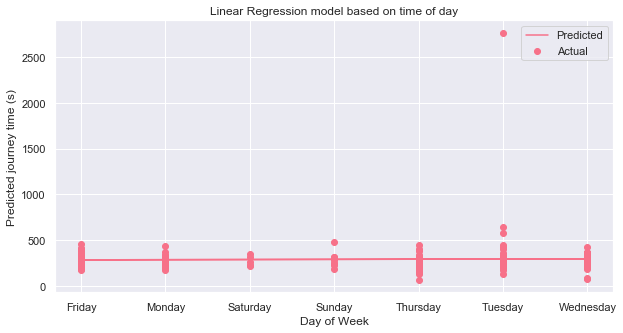

In [97]:
# Plot outputs
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x_test, y_test, label = "Actual")
ax.plot(x_test, y_pred, label = "Predicted")
ax.set_title("Linear Regression model based on day of week")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Predicted journey time (s)")
ax.legend()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(days_of_week_label)
plt.show()

CONCLUSIONS:
We can see that a linear regression model does not fit well with these parameters. There is not enough of a difference in journey times over different days of the week

## Multiple predictor variables == Multiple Linear Regression

In [111]:
from sklearn.metrics import mean_squared_error, r2_score

y_train = training['Journey Time (s)']
y_test = validation['Journey Time (s)']

# Encode the data
le = preprocessing.LabelEncoder()
le.fit(training['Day of Week'])
days_of_week_label = list(le.inverse_transform([0,1,2,3,4,5,6]))
first_attr_tr = le.transform(training['Day of Week'])
first_attr_te = le.transform(validation['Day of Week'])
second_attr_tr = training['Time of Day']
second_attr_te = validation['Time of Day']
x_train = np.array(list(zip(first_attr_tr, second_attr_tr)))
x_train = x_train.reshape(-1, 2)
x_test = np.array(list(zip(first_attr_te, second_attr_te)))
x_test = x_test.reshape(-1, 2)
print(x_train.shape)

# Scale the data
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Fit model
linreg = LinearRegression()
linreg.fit(x_scaled, y_train)

# Apply the model to the validation data to predict the ‘Journey Time’
y_pred = linreg.predict(x_test)

# Calculate measures of success
mse = mean_squared_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

print('Slope/Coefficients: ', linreg.coef_)
print('Intercept: ', linreg.intercept_)
print('The mean squared error is: ', mse)
# coefficient of determination = 1 is perfect prediction
print('The coefficient of determination is: ', r2_score)

(664, 2)
Slope/Coefficients:  [3.75015245 5.23304909]
Intercept:  292.62048192771084
The mean squared error is:  48052.04890551227
The coefficient of determination is:  -0.009848454520837047
